# Import libraries

In [1]:
library("dimRed")

Warning message:
"package 'dimRed' was built under R version 3.5.3"Loading required package: DRR
Warning message:
"package 'DRR' was built under R version 3.5.3"Loading required package: kernlab
Warning message:
"package 'kernlab' was built under R version 3.5.2"Loading required package: CVST
Warning message:
"package 'CVST' was built under R version 3.5.3"Loading required package: Matrix

Attaching package: 'dimRed'

The following object is masked from 'package:stats':

    embed

The following object is masked from 'package:base':

    as.data.frame



In [2]:
library("TDA")

Warning message:
"package 'TDA' was built under R version 3.5.3"

# Import data

In [3]:
fileName <- "C:\\Users\\Daria\\Documents\\Skoltech\\Diploma\\biology\\google_drive\\CA1_6_1D_NB_fine_cells.csv"

MyData <- read.csv(file=fileName, header=TRUE, sep=",")

MyDataNoTime <- MyData[,2:25]

# Dimensional reduction and sparsification

In [4]:
MyObject <- as(MyDataNoTime, "dimRedData")

LEM <-  LaplacianEigenmaps()

LemParam <- LEM@stdpars
LemParam$knn <- 600

emb <- LEM@fun(MyObject, LemParam)

Data2d <- emb@data@data

2019-05-30 17:12:39: Creating weight matrix
2019-05-30 17:12:53: Eigenvalue decomposition
Eigenvalues: 1.912139e-01 1.712917e-01 1.807484e-16
2019-05-30 17:13:17: DONE


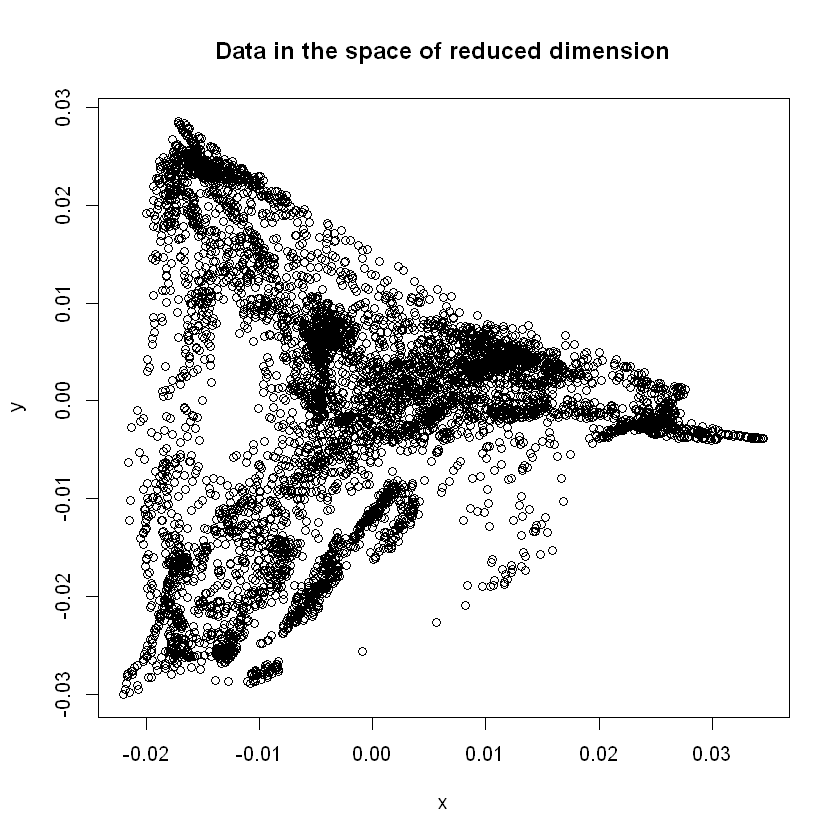

In [5]:
plot(Data2d, main = "Data in the space of reduced dimension", xlab = "x", ylab="y",  pch = 1)

In [6]:
Data2d_table <- as.table(Data2d)

# Kernel Density Estimator Persistence Diagram

In [8]:
Xlim <- c(-0.05, 0.05);
Ylim <- c(-0.05, 0.05);
by <- 0.001;
Xseq <- seq(Xlim[1], Xlim[2], by = by)
Yseq <- seq(Ylim[1], Ylim[2], by = by)
Grid <- expand.grid(Xseq, Yseq)

In [9]:
h <- 0.001

Data2d_table.kde <- kde(X = Data2d_table, Grid = Grid, h = h, kertype = "Gaussian", weight = 1,
    printProgress = FALSE)

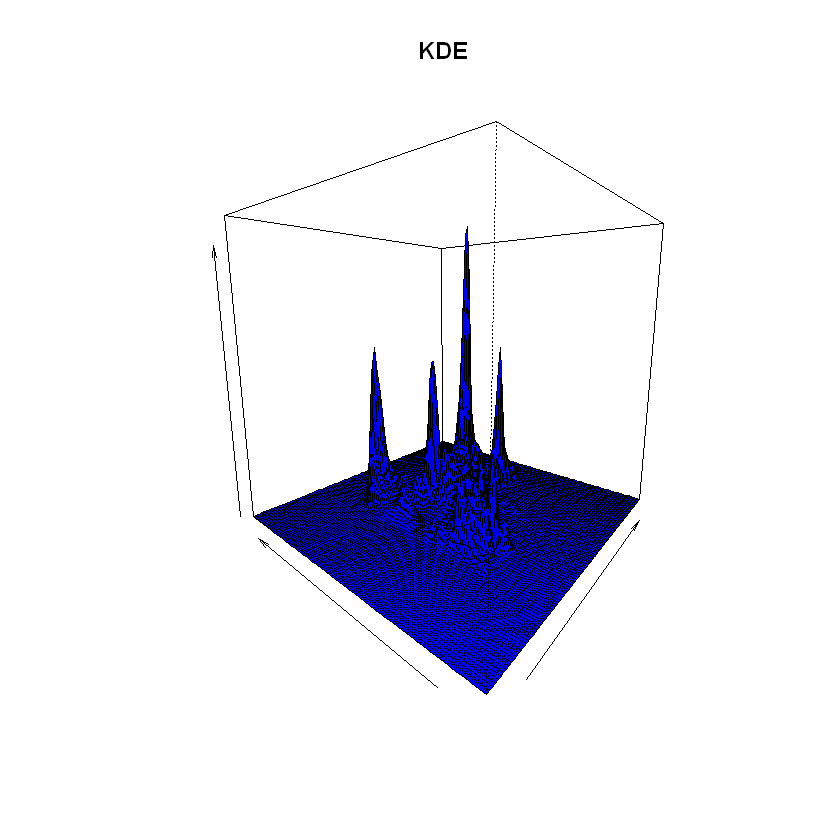

In [10]:
persp(Xseq, Yseq,
      matrix(Data2d_table.kde,ncol = length(Yseq), nrow = length(Xseq)),
      xlab = "",ylab = "", zlab = "",
      theta = -50, phi = 10, ltheta = 50,col = "blue", 
      main = "KDE", d = 0.5)

In [11]:
Data2d_table.kde.Diag <- gridDiag(X = Data2d_table, FUN = kde, h=h,
                          lim = cbind(Xlim, Ylim),by = by,
                          sublevel = FALSE,
                          library = "Dionysus", 
                          printProgress = TRUE)

# Generated complex of size: 60401 

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
# Persistence timer: Elapsed time [ 0.368000 ] seconds


In [12]:
supnor <- function(data,indices){
  data.extract <- data[indices,]
  hatf <- kde(X = data.extract, Grid = Grid, h = h)
  supnorm <- max(abs(hatf - Data2d_table.kde))
  return(supnorm)
}

In [13]:
start_time <- Sys.time()


library(boot)
supnor.boot <- boot(data= Data2d_table,
                    statistic=supnor,
                    R=100,
                    parallel="multicore",
                    ncpus=4
                    )
q95 <- quantile(supnor.boot$t,probs = 0.95)
print(q95)

end_time <- Sys.time()

print(end_time - start_time)

     95% 
798.2438 
Time difference of 1.188454 mins


In [14]:
supnor.bottle <- function(data,indices){
  data.extract <- data[indices,]
  Data2d_table.kde.Diag.boot <- gridDiag(X = data.extract, FUN = kde, h = h,
                            lim = cbind(Xlim, Ylim),by = by,
                            sublevel = FALSE, library = "Dionysus",
                            printProgress = FALSE)
  
  bottle <- bottleneck(Data2d_table.kde.Diag.boot$diagram, Data2d_table.kde.Diag$diagram)
  return(bottle)
}

In [15]:
start_time <- Sys.time()

bottle.boot <- boot(data=Data2d_table,
                    statistic=supnor.bottle,
                    R=100,
                    parallel="multicore",
                    ncpus=4
                    )
q95.bottle <- quantile(bottle.boot$t,probs = 0.95)
print(q95.bottle)

end_time <- Sys.time()

print(end_time - start_time)

     95% 
139.9111 
Time difference of 1.629853 mins


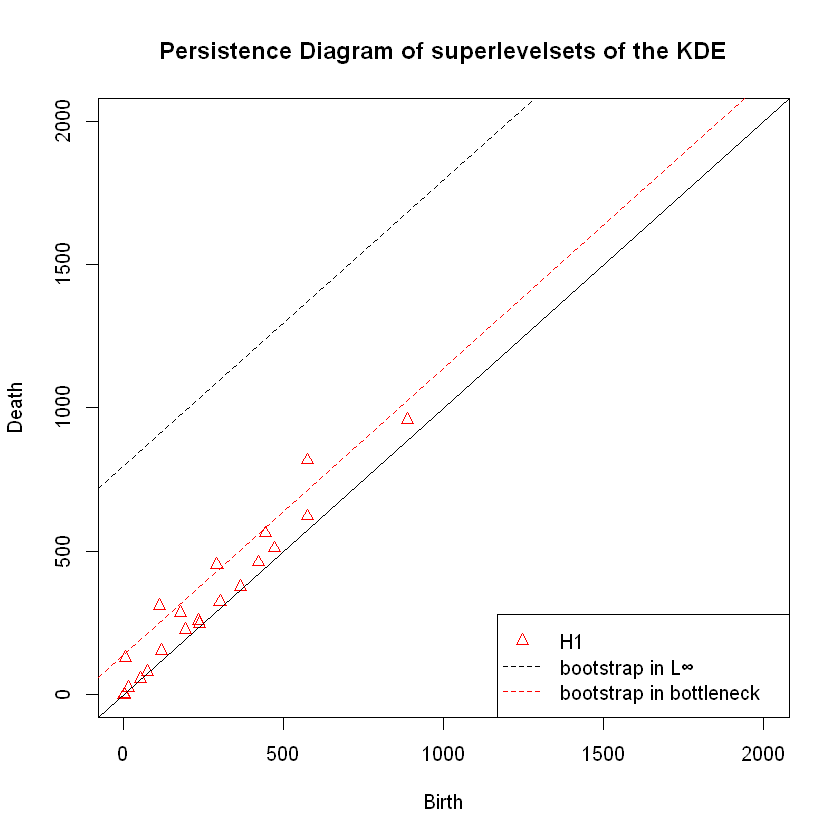

In [16]:
is_1_dim <- (Data2d_table.kde.Diag[["diagram"]] == 1)
is_1_dim <- is_1_dim[,1]
diag_dim1 <- Data2d_table.kde.Diag[["diagram"]][is_1_dim,]

plot(diag_dim1[,2], diag_dim1[,3], pch = 2, col = "red", xlim=c(0,2000), ylim=c(0,2000), xlab = "Birth", 
     ylab = "Death", main = "Persistence Diagram of superlevelsets of the KDE")
abline(coef = c(0,1))
abline(q95,1, col = "black", lty = 2)
abline(q95.bottle,1, col = "red", lty = 2)


legend("bottomright", c("H1","bootstrap in L\U221E", "bootstrap in bottleneck"), pch = c(2,NA,NA), 
       col = c("red", "black", "red"), lty = c(NA,2,2))

# Distance To Measure Persistence Diagrams

In [17]:
Xlim <- c(-0.05, 0.05);
Ylim <- c(-0.05, 0.05);
by <- 0.001;
Xseq <- seq(Xlim[1], Xlim[2], by = by)
Yseq <- seq(Ylim[1], Ylim[2], by = by)
Grid <- expand.grid(Xseq, Yseq)

In [18]:
m0=0.002

Data2d_table.dtm <- dtm(X = Data2d_table, Grid = Grid, m0=m0)

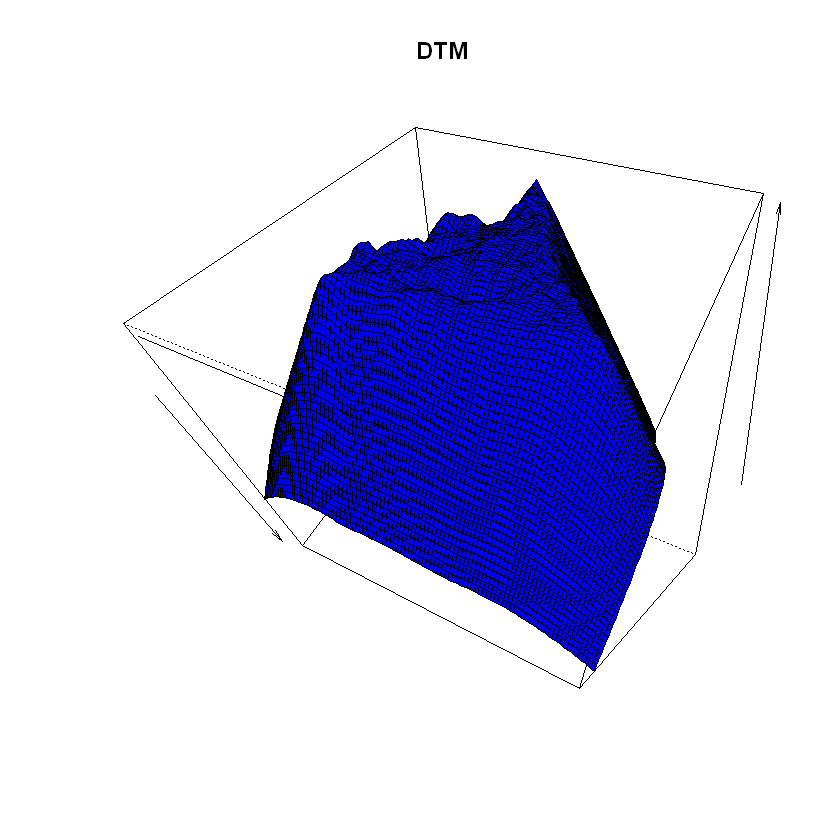

In [19]:
persp(Xseq, Yseq,
      matrix(Data2d_table.dtm,ncol = length(Yseq), nrow = length(Xseq)),
      xlab = "",ylab = "", zlab = "",
      theta = -295, phi = 230, ltheta = 50,col = "blue", 
      main = "DTM", d = 0.5)

In [20]:
Data2d_table.dtm.Diag <- gridDiag(X = Data2d_table, FUN = dtm, m0=m0,
                          lim = cbind(Xlim, Ylim),by = by,
                          sublevel = TRUE,
                          library = "Dionysus", 
                          printProgress = TRUE)

# Generated complex of size: 60401 

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
# Persistence timer: Elapsed time [ 0.215000 ] seconds


In [32]:
supnor <- function(data,indices){
  data.extract <- data[indices,]
  hatf <- dtm(X = data.extract, Grid = Grid, m0 = m0)
  supnorm <- max(abs(hatf - Data2d_table.dtm))
  return(supnorm)
}

In [33]:
start_time <- Sys.time()


library(boot)
supnor.boot <- boot(data= Data2d_table,
                    statistic=supnor,
                    R=100,
                    parallel="multicore",
                    ncpus=4
                    )
q95 <- quantile(supnor.boot$t,probs = 0.95)
print(q95)

end_time <- Sys.time()

print(end_time - start_time)

        95% 
0.002071082 
Time difference of 3.068179 secs


In [23]:
supnor.bottle <- function(data,indices){
  data.extract <- data[indices,]
  Data2d_table.dtm.Diag.boot <- gridDiag(X = data.extract, FUN = dtm, m0 = m0,
                            lim = cbind(Xlim, Ylim),by = by,
                            sublevel = TRUE, library = "Dionysus",
                            printProgress = FALSE)
  
  bottle <- bottleneck(Data2d_table.dtm.Diag.boot$diagram, Data2d_table.dtm.Diag$diagram)
  return(bottle)
}

In [24]:
set.seed(1240)

start_time <- Sys.time()

bottle.boot <- boot(data=Data2d_table,
                    statistic=supnor.bottle,
                    R=100,
                    parallel="multicore",
                    ncpus=4
                    )
q95.bottle <- quantile(bottle.boot$t,probs = 0.95)
print(q95.bottle)

end_time <- Sys.time()

print(end_time - start_time)

         95% 
0.0005926634 
Time difference of 56.88466 secs


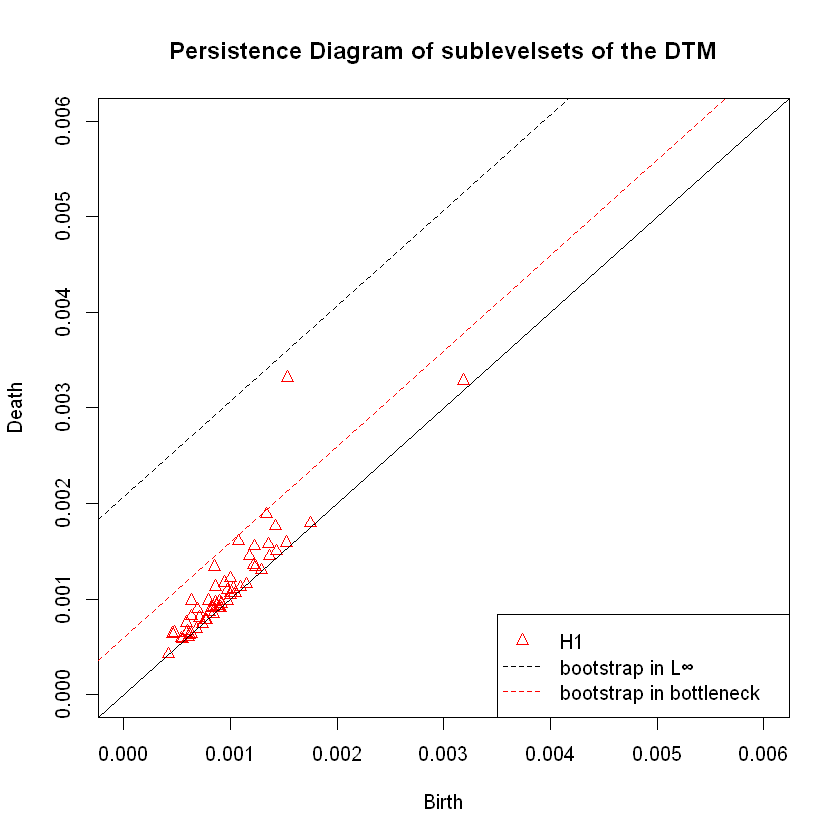

In [34]:
is_1_dim <- (Data2d_table.dtm.Diag[["diagram"]] == 1)
is_1_dim <- is_1_dim[,1]
diag_dim1 <- Data2d_table.dtm.Diag[["diagram"]][is_1_dim,]

plot(diag_dim1[,2], diag_dim1[,3], pch = 2, col = "red", xlim = c(0, 0.006), ylim = c(0, 0.006), xlab = "Birth", 
     ylab = "Death", main = "Persistence Diagram of sublevelsets of the DTM")
abline(coef = c(0,1))
abline(q95,1, col = "black", lty = 2)
abline(q95.bottle,1, col = "red", lty = 2)


legend("bottomright", c("H1","bootstrap in L\U221E", "bootstrap in bottleneck"), pch = c(2,NA,NA), 
       col = c("red", "black", "red"), lty = c(NA,2,2))